In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import random

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [2]:
observations = []
actions  = []

# ['smm', 'icm', 'icm_apt', 'disagreement', 'proto', 'diayn', 'aps', 'rnd']
for ualgo in ['icm_apt']:
    npz_files = os.listdir(f'datasets/point_mass_maze/{ualgo}/buffer/')
    for file_name in tqdm(npz_files, desc=ualgo):
        data = np.load(f'datasets/point_mass_maze/{ualgo}/buffer/{file_name}')
        observations.append(data['observation'])
        actions.append(data['action'])
    
observations = np.concatenate(observations)
actions = np.concatenate(actions)

icm_apt: 100%|██████████| 11037/11037 [00:06<00:00, 1727.80it/s]


## Evaluation reward functions:

In [80]:
def eval_goal_reaching_reward(p1, p2):
    
    def reward(obs):
        x1 = p1*(observations[:, 0].max() - observations[:, 0].min()) + observations[:, 0].min()
        x2 = p2*(observations[:, 1].max() - observations[:, 1].min()) + observations[:, 1].min()

        random_ids = torch.randint(0, observations.shape[0], (10000,))
        goal_idx = np.linalg.norm(observations[random_ids, :2] - np.array([x1, x2]), axis=-1).argmin()
        goal = observations[random_ids][goal_idx]

        r = 1 - np.linalg.norm(obs - goal, axis=-1) * 10
        r = np.clip(r, -1, 1)
        r = (r > 0.0) * 2 - 1
        
        return r
    
    return reward


def eval_multiple_goal_reaching_reward(points):
    
    def reward(obs):
        reward = []
        for point in points:
            r = eval_goal_reaching_reward(*point)(obs)
            reward.append(r)
        reward = np.max(np.stack(reward), axis=0)
        return reward
    
    return reward


def eval_uni_modal_reward(p1, p2):
    def reward(obs):
        x1 = p1*(observations[:, 0].max() - observations[:, 0].min()) + observations[:, 0].min()
        x2 = p2*(observations[:, 1].max() - observations[:, 1].min()) + observations[:, 1].min()

        random_ids = torch.randint(0, observations.shape[0], (10000,))
        goal_idx = np.linalg.norm(observations[random_ids, :2] - np.array([x1, x2]), axis=-1).argmin()
        goal = observations[random_ids][goal_idx]
        
        r = (2 - 8*np.linalg.norm(obs - goal, axis=-1))
        # print(r.min(), r.max())
        r = np.clip(r, -1, 1)
        # r = (r > 0.0) * 2 - 1
        return r
    return reward
    
    
def eval_multiple_modal_reward(points):
    
    def reward(obs):
        reward = []
        for point in points:
            r = eval_uni_modal_reward(*point)(obs)
            # r = (r > 0) * 1
            reward.append(r)
        reward = np.max(np.stack(reward), axis=0)
        # print(reward.shape)
        return reward
    
    return reward



def eval_cos_reward(obs, a, b):
    rewards = np.cos((a*obs[:, 0]+ b*obs[:, 1])*40)
    return rewards



eval_direction_t  = lambda obs: (obs[:, 1:].sum(axis=-1)) * 3
eval_direction_b  = lambda obs: (- obs[:, 1:].sum(axis=-1)) * 3
eval_direction_r  = lambda obs: (obs[:, 0] + obs[:, 2:].sum(axis=-1)) * 3
eval_direction_l  = lambda obs: (-obs[:, 0] + obs[:, 2:].sum(axis=-1)) * 3
eval_direction_tr = lambda obs: obs.sum(axis=-1) * 2
eval_direction_bl = lambda obs: -obs.sum(axis=-1) * 2
eval_direction_tl = lambda obs: (- obs[:, 0] + obs[:, 1:].sum(axis=-1)) * 2
eval_direction_br = lambda obs: (+ obs[:, 0] - obs[:, 1:].sum(axis=-1)) * 2


eval_goal_1 = lambda obs: eval_goal_reaching_reward(0.2, 0.2)(obs)
eval_goal_2 = lambda obs: eval_goal_reaching_reward(0.2, 0.5)(obs)
eval_goal_3 = lambda obs: eval_goal_reaching_reward(0.2, 0.8)(obs)
eval_goal_4 = lambda obs: eval_goal_reaching_reward(0.5, 0.2)(obs)
eval_goal_5 = lambda obs: eval_goal_reaching_reward(0.5, 0.5)(obs)
eval_goal_6 = lambda obs: eval_goal_reaching_reward(0.5, 0.8)(obs)
eval_goal_7 = lambda obs: eval_goal_reaching_reward(0.8, 0.2)(obs)
eval_goal_8 = lambda obs: eval_goal_reaching_reward(0.8, 0.5)(obs)
eval_goal_9 = lambda obs: eval_goal_reaching_reward(0.8, 0.8)(obs)


eval_multiple_goals_1 = lambda obs: eval_multiple_goal_reaching_reward([(0.3, 0.9), (0.9, 0.9)])(obs)
eval_multiple_goals_2 = lambda obs: eval_multiple_goal_reaching_reward([(0.6, 0.6), (0.6, 0.8)])(obs)
eval_multiple_goals_3 = lambda obs: eval_multiple_goal_reaching_reward([(0.2, 0.6), (0.7, 0.4)])(obs)
eval_multiple_goals_4 = lambda obs: eval_multiple_goal_reaching_reward([(0.8, 0.6), (0.2, 0.9)])(obs)
eval_multiple_goals_5 = lambda obs: eval_multiple_goal_reaching_reward([(0.8, 0.1), (0.9, 0.6)])(obs)
eval_multiple_goals_6 = lambda obs: eval_multiple_goal_reaching_reward([(0.3, 0.3), (0.9, 0.8), (0.3, 0.8)])(obs)
eval_multiple_goals_7 = lambda obs: eval_multiple_goal_reaching_reward([(0.3, 0.6), (0.1, 0.8), (0.7, 0.6)])(obs)
eval_multiple_goals_8 = lambda obs: eval_multiple_goal_reaching_reward([(0.9, 0.6), (0.3, 0.1), (0.3, 0.9)])(obs)
eval_multiple_goals_9 = lambda obs: eval_multiple_goal_reaching_reward([(0.8, 0.5), (0.8, 0.2), (0.5, 0.4)])(obs)
eval_multiple_goals_10 = lambda obs: eval_multiple_goal_reaching_reward([(0.4, 0.4), (0.7, 0.9), (0.2, 0.1)])(obs)


eval_uni_mode_1 = lambda obs: eval_uni_modal_reward(0.2, 0.2)(obs)
eval_uni_mode_2 = lambda obs: eval_uni_modal_reward(0.2, 0.5)(obs)
eval_uni_mode_3 = lambda obs: eval_uni_modal_reward(0.2, 0.8)(obs)
eval_uni_mode_4 = lambda obs: eval_uni_modal_reward(0.5, 0.2)(obs)
eval_uni_mode_5 = lambda obs: eval_uni_modal_reward(0.5, 0.5)(obs)
eval_uni_mode_6 = lambda obs: eval_uni_modal_reward(0.5, 0.8)(obs)
eval_uni_mode_7 = lambda obs: eval_uni_modal_reward(0.8, 0.2)(obs)
eval_uni_mode_8 = lambda obs: eval_uni_modal_reward(0.8, 0.5)(obs)
eval_uni_mode_9 = lambda obs: eval_uni_modal_reward(0.8, 0.8)(obs)


eval_multiple_modes_1 = lambda obs: eval_multiple_modal_reward([(0.3, 0.9), (0.9, 0.9)])(obs)
eval_multiple_modes_2 = lambda obs: eval_multiple_modal_reward([(0.6, 0.6), (0.6, 0.8)])(obs)
eval_multiple_modes_3 = lambda obs: eval_multiple_modal_reward([(0.2, 0.6), (0.7, 0.4)])(obs)
eval_multiple_modes_4 = lambda obs: eval_multiple_modal_reward([(0.8, 0.6), (0.2, 0.9)])(obs)
eval_multiple_modes_5 = lambda obs: eval_multiple_modal_reward([(0.8, 0.1), (0.9, 0.6)])(obs)
eval_multiple_modes_6 = lambda obs: eval_multiple_modal_reward([(0.3, 0.3), (0.9, 0.8), (0.3, 0.8)])(obs)
eval_multiple_modes_7 = lambda obs: eval_multiple_modal_reward([(0.3, 0.6), (0.1, 0.8), (0.7, 0.6)])(obs)
eval_multiple_modes_8 = lambda obs: eval_multiple_modal_reward([(0.9, 0.6), (0.3, 0.1), (0.3, 0.9)])(obs)
eval_multiple_modes_9 = lambda obs: eval_multiple_modal_reward([(0.8, 0.5), (0.8, 0.2), (0.5, 0.4)])(obs)
eval_multiple_modes_10 = lambda obs: eval_multiple_modal_reward([(0.4, 0.4), (0.7, 0.9), (0.2, 0.1)])(obs)

eval_cos_1 = lambda obs: eval_cos_reward(obs, 1, 0)
eval_cos_2 = lambda obs: eval_cos_reward(obs, 1, 1)
eval_cos_3 = lambda obs: eval_cos_reward(obs, 0, 1)
eval_cos_4 = lambda obs: eval_cos_reward(obs, -1, 1)


# viz_ids = torch.randint(0, observations.shape[0], (10000,))
# obs = observations[viz_ids]

# rewards = eval_cos_1(obs)

# rewards = np.clip(rewards, -1, 1)
# plt.scatter(observations[viz_ids, 0], observations[viz_ids, 1], vmin=-1, vmax=1)
# plt.scatter(observations[viz_ids, 0], observations[viz_ids, 1], c=rewards, vmin=-1, vmax=1)

In [82]:
class EvalRewards:
    def __init__(self):
        
        self.reward_functions = {
            'eval_direction_t': eval_direction_t,
            'eval_direction_b': eval_direction_b,
            'eval_direction_r': eval_direction_r,
            'eval_direction_l': eval_direction_l,
            'eval_direction_tr': eval_direction_tr,
            'eval_direction_bl': eval_direction_bl,
            'eval_direction_tl': eval_direction_tl,
            'eval_direction_br': eval_direction_br,
            
            'eval_goal_1': eval_goal_1,
            'eval_goal_2': eval_goal_2,
            'eval_goal_3': eval_goal_3,
            'eval_goal_4': eval_goal_4,
            'eval_goal_5': eval_goal_5,
            'eval_goal_6': eval_goal_6,
            'eval_goal_7': eval_goal_7,
            'eval_goal_8': eval_goal_8,
            'eval_goal_9': eval_goal_9,

            'eval_multiple_goals_1': eval_multiple_goals_1,
            'eval_multiple_goals_2': eval_multiple_goals_2,
            'eval_multiple_goals_3': eval_multiple_goals_3,
            'eval_multiple_goals_4': eval_multiple_goals_4,
            'eval_multiple_goals_5': eval_multiple_goals_5,
            'eval_multiple_goals_6': eval_multiple_goals_6,
            'eval_multiple_goals_7': eval_multiple_goals_7,
            'eval_multiple_goals_8': eval_multiple_goals_8,
            'eval_multiple_goals_9': eval_multiple_goals_9,
            'eval_multiple_goals_10': eval_multiple_goals_10,
            
            'eval_uni_mode_1': eval_uni_mode_1,
            'eval_uni_mode_2': eval_uni_mode_2,
            'eval_uni_mode_3': eval_uni_mode_3,
            'eval_uni_mode_4': eval_uni_mode_4,
            'eval_uni_mode_5': eval_uni_mode_5,
            'eval_uni_mode_6': eval_uni_mode_6,
            'eval_uni_mode_7': eval_uni_mode_7,
            'eval_uni_mode_8': eval_uni_mode_8,
            'eval_uni_mode_9': eval_uni_mode_9,
            
            'eval_multiple_modes_1': eval_multiple_modes_1,
            'eval_multiple_modes_2': eval_multiple_modes_2,
            'eval_multiple_modes_3': eval_multiple_modes_3,
            'eval_multiple_modes_4': eval_multiple_modes_4,
            'eval_multiple_modes_5': eval_multiple_modes_5,
            'eval_multiple_modes_6': eval_multiple_modes_6,
            'eval_multiple_modes_7': eval_multiple_modes_7,
            'eval_multiple_modes_8': eval_multiple_modes_8,
            'eval_multiple_modes_9': eval_multiple_modes_9,
            'eval_multiple_modes_10': eval_multiple_modes_10,
            
            'eval_cos_1': eval_cos_1,
            'eval_cos_2': eval_cos_2,
            'eval_cos_3': eval_cos_3,
            'eval_cos_4': eval_cos_4,
        }
        
        pass
    
    def __call__(self, obs):
        assert len(obs.shape) == 2, obs.shape
        
        obs = obs if isinstance(obs, np.ndarray) else np.array(obs.detach().cpu())
        
        rewards = {}
        for key, reward_function in tqdm(self.reward_functions.items(), desc='Eval'):
            rewards[key] = reward_function(obs)
            
        return rewards
        
# eval_rewards = EvalRewards()
# viz_ids = torch.randint(0, observations.shape[0], (20000,))
# obs = observations[viz_ids]

In [83]:
# rewards_dict = eval_rewards(obs)

## Random reward functions:

In [84]:
class MLPRewards:
    def __init__(self, N, obs_len):

        self.N = N
        
        self.param_w1 = torch.normal(0, 3, size=(self.N, obs_len, 32)) * np.sqrt(1/32)
        self.param_b1 = torch.normal(0, 0.001, size=(self.N, 1, 32)) * np.sqrt(16)
        self.param_w2 = torch.normal(0, 3, size=(self.N, 32, 1)) * np.sqrt(1/16)
        
        # self.param_w1 = torch.normal(0, 1, size=(self.N, obs_len, 32))
        # self.param_b1 = torch.normal(0, 1, size=(self.N, 1, 32))
        # self.param_w2 = torch.normal(0, 1, size=(self.N, 32, 1))
        
        

    def __call__(self, obs, param_id=None):
        
        if param_id is None:
            param_id = torch.randint(0, self.N, size=(obs.shape[0], 1))
        
        param_id_expanded = param_id.repeat(1, obs.shape[1])
        
        param1_w = self.param_w1[param_id_expanded]
        param1_b = self.param_b1[param_id_expanded]
        param2_w = self.param_w2[param_id_expanded]

        x = torch.unsqueeze(obs, -2) # [batch, (pairs), 1, features_in]
        x = torch.matmul(x.cpu(), param1_w) # [batch, (pairs), 1, features_out]
        x = x + param1_b
        x = torch.tanh(x)
        r = torch.matmul(x, param2_w) # [batch, (pairs), 1, 1]
        r = r.squeeze(-1).squeeze(-1) # [batch, (pairs)]
        r = torch.clip(r, -1, 1)

        return r, param_id

In [85]:
class GoalRewards:
    def __init__(self, N, obs_len=4):
        self.obs_len = obs_len
        self.N = N
        
        random_goals = torch.rand((N,obs_len))
        for i in range(obs_len):
            random_goals[:, i] = random_goals[:, i] * (observations[:, i].max() - observations[:, i].min()) + observations[:, i].min()
        self.random_goals = random_goals
    
    def __call__(self, obs, goals=None):
        batch_size, n_pairs = obs.shape[:2]
        
        obs = obs.cpu()
        assert (goals is None) or (goals.shape == (batch_size, self.obs_len))
        
        if goals is None:
            
            random_indices = torch.randint(0, n_pairs, (batch_size,)) 
            goals = obs[torch.arange(batch_size), random_indices]
            
            # random_indices = torch.randint(0, len(observations), (batch_size,)) 
            # goals = observations[torch.arange(batch_size), random_indices]
            
            # random_indices = torch.randint(0, self.N, (batch_size,)) 
            # goals = torch.tensor(self.random_goals[random_indices])
            
            if len(goals.shape) == 1:
                goals = goals.reshape(1, -1)

        # print(goals)
        # print(obs.shape, goals.shape)
        r = 1 - torch.norm(obs - goals.unsqueeze(-2), dim=-1) * 10
        r = torch.clip(r, -1, 1)
        r = (r > 0.0).float() * 2 - 1

        return r, goals

## FRE:

In [86]:
class FRENetwork(nn.Module):
    def __init__(self, num_heads=2, num_layers=2, reward_pairs_emb_dim=128):
        super().__init__()
        
        self.obs_len = 4
        self.reward_pairs_emb_dim = reward_pairs_emb_dim
        self.num_discrete_embeddings = 32
        
        self.encoder_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                self.reward_pairs_emb_dim, 
                num_heads, 
                dim_feedforward=4*self.reward_pairs_emb_dim, 
                batch_first=True
            ),
            num_layers=num_layers
        )
        self.encoder_mean = nn.Linear(self.reward_pairs_emb_dim, self.reward_pairs_emb_dim)
        self.encoder_log_std = nn.Linear(self.reward_pairs_emb_dim, self.reward_pairs_emb_dim)

        self.reward_embed = nn.Embedding(self.num_discrete_embeddings, self.reward_pairs_emb_dim // 2)
        self.state_embed = nn.Linear(self.obs_len, self.reward_pairs_emb_dim // 2)

        self.reward_predict = nn.Sequential(
            nn.Linear(self.obs_len + self.reward_pairs_emb_dim, 512),
            nn.LayerNorm(512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.Mish(),
            nn.Linear(512, 1),
        )


    def get_transformer_encoding(self, reward_state_pairs):
        reward_states = reward_state_pairs[:, :, :-1]
        reward_values = reward_state_pairs[:, :, -1]
        reward_values_idx = torch.floor((reward_values / 2.0 + 0.5) * self.num_discrete_embeddings).int()
        reward_values_idx = torch.clip(reward_values_idx, 0, self.num_discrete_embeddings - 1)
        # unique_counts = torch.tensor([torch.unique(row).numel() for row in reward_values_idx])
        # print(unique_counts)
        
        # plt.hist(reward_values_idx[0].cpu().detach())
        # plt.show()
        
        reward_state_emb = self.state_embed(reward_states)
        reward_state_val = self.reward_embed(reward_values_idx)
        
        reward_state_pairs = torch.concatenate([reward_state_emb, reward_state_val], axis=-1)

        w_pre = self.encoder_transformer(reward_state_pairs) # [batch, reward_pairs, emb_dim]
        # print(w_pre.shape)
        
        w_pair_mean = w_pre.mean(axis=1)
        # print(w_pair_mean.shape)
        w_mean = self.encoder_mean(w_pair_mean)
        w_log_std = self.encoder_log_std(w_pair_mean)

        return w_mean, w_log_std # (batch_size, emb_dim)
    
    
    def get_reward_pred(self, w, reward_states): # Reward Pairs: [batch, reward_pairs, obs_dim + 1]
        z_expand = w.unsqueeze(1) # [batch, 1, emb_dim]
        z_expand = z_expand.repeat(1, reward_states.shape[1], 1)        
        
        w_and_obs = torch.concatenate([z_expand, reward_states], axis=-1)
        
        reward_pred = self.reward_predict(w_and_obs)
        
        return reward_pred # [batch, reward_pairs]
        

In [87]:
class RandomReward:
    def __init__(self, obs_len=4, mlp_N=10000, goal_N=10000):
        
        
        self.mlp_rewards = MLPRewards(N=mlp_N, obs_len=obs_len)
        self.goal_rewards = GoalRewards(N=goal_N, obs_len=obs_len)
    
    def __call__(self, obs, param_id=None, goals=None, mlp_p=0.5):
        
        batch_size, n_pairs = obs.shape[:2]
        
        mlp_n_samples = int(mlp_p * batch_size)
        goal_n_samples = batch_size - mlp_n_samples
        
        mlp_obs = obs[:mlp_n_samples]
        goal_obs = obs[mlp_n_samples:]
        
        
        if mlp_obs.shape[0] != 0:
            mlp_r, param_id = self.mlp_rewards(mlp_obs, param_id=param_id)
        else:
            mlp_r = torch.zeros(size=(0, n_pairs))
        
        
        if goal_obs.shape[0] != 0:
            goal_r, goals = self.goal_rewards(goal_obs, goals=goals)
        else:
            goal_r = torch.zeros(size=(0, n_pairs))
            
        
        r = torch.concat((mlp_r, goal_r), dim=0)
        
        
        return r, (param_id, goals)

In [88]:
def train_fre(fre_network, optimimizer, train_observations, random_rewards, viz_loss=False, steps=2000, mlp_p=0.5):

    losses = []

    for i in tqdm(range(steps)):
        
        encode_obs = torch.tensor(train_observations[torch.randint(0, train_observations.shape[0], (256*128,))].reshape(256, 128, 4)).to(device)
        decode_obs = torch.tensor(train_observations[torch.randint(0, train_observations.shape[0], (256*128,))].reshape(256, 128, 4)).to(device)
        
        encode_rewards, (param_id, goals) = random_rewards(encode_obs, mlp_p=mlp_p)
        decode_rewards, (param_id, goals) = random_rewards(decode_obs, param_id=param_id, goals=goals, mlp_p=mlp_p)
        
        # encode_rewards, goals = goal_rewards(encode_obs, goals=None)
        # decode_rewards, goals = goal_rewards(decode_obs, goals=goals)
        
        encode_rewards, decode_rewards = encode_rewards.unsqueeze(-1).to(device), decode_rewards.unsqueeze(-1).to(device)

        reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
        
        w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)
        
        
        # Calculate the loss:
        
        w = w_mean + torch.normal(0, 1, size=w_mean.shape, device=device) * torch.exp(w_log_std)
        # w = w_mean
        rewards_pred = fre_network.get_reward_pred(w, decode_obs)
        
        reward_pred_loss = ((rewards_pred - decode_rewards)**2).mean()
        kl_loss = -0.5 * (1 + w_log_std - w_mean**2 - torch.exp(w_log_std)).mean()
        reward_kl_loss = reward_pred_loss + kl_loss * 0.01
        loss = reward_kl_loss
        
        optimimizer.zero_grad()
        loss.backward()
        optimimizer.step()
        
        losses.append(loss.item())
        # break
        if viz_loss and i % 20 == 0:
            clear_output(True)
            plt.plot(losses)
            plt.ylim([0, 0.5])
            plt.show()
            
    return losses
            

In [89]:
# torch.save(fre_network.state_dict(), 'fre_network_point_maze_.pth')
# fre_network.load_state_dict(torch.load('fre_network_point_maze.pth'))

In [90]:
def visualize_fre(fre_network, random_rewards):
    fig, axs = plt.subplots(2, 10, figsize=(40, 8), constrained_layout=True)

    viz_ids = torch.randint(0, observations.shape[0], (20000,))

    for col in range(10):

        real_rewards, (eval_param_id, eval_goals) = random_rewards(torch.tensor(observations[viz_ids]).unsqueeze(0), mlp_p=1 if col < 5 else 0)

        encode_obs = torch.tensor(observations[torch.randint(0, observations.shape[0], (1*256,))].reshape(1, -1, 4)).to(device)
        decode_obs = torch.tensor(observations[viz_ids].reshape(1, -1, 4)).to(device)

        encode_rewards, _ = random_rewards(encode_obs, eval_param_id, eval_goals, mlp_p=1 if col < 5 else 0)
        encode_rewards = encode_rewards.unsqueeze(-1).to(device)
        

        reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
        w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)

        w = w_mean + torch.normal(0, 1, size=w_mean.shape, device=device) * torch.exp(w_log_std)

        pred_rewards = fre_network.get_reward_pred(w, decode_obs).detach().cpu()

        real_rewards = real_rewards.reshape(-1)
        pred_rewards = pred_rewards.reshape(-1)

        # Plot Real Rewards
        sc1 = axs[0, col].scatter(observations[viz_ids, 0], observations[viz_ids, 1], c=real_rewards, vmin=-1, vmax=1, s=10)
        axs[0, col].set_title(f"Real Reward", fontsize=12)

        # Plot Predicted Rewards
        sc2 = axs[1, col].scatter(observations[viz_ids, 0], observations[viz_ids, 1], c=pred_rewards, vmin=-1, vmax=1, s=10)
        axs[1, col].set_title(f"Predicted Reward", fontsize=12)
        
        # break

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(sc1, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Reward", fontsize=12)

    plt.show()


In [91]:
def get_fre_performance(fre_network, random_rewards):
    mlp_performance = []
    goal_performance = []

    viz_ids = torch.randint(0, observations.shape[0], (20000,))

    for exp_id in tqdm(range(1000)):

        is_mlp = 1 if exp_id < 50 else 0
        
        real_rewards, (eval_param_id, eval_goals) = random_rewards(torch.tensor(observations[viz_ids]).unsqueeze(0), mlp_p=is_mlp)

        encode_obs = torch.tensor(observations[torch.randint(0, observations.shape[0], (1*256,))].reshape(1, -1, 4)).to(device)
        decode_obs = torch.tensor(observations[viz_ids].reshape(1, -1, 4)).to(device)

        encode_rewards, _ = random_rewards(encode_obs, eval_param_id, eval_goals, mlp_p=is_mlp)
        encode_rewards = encode_rewards.unsqueeze(-1).to(device)
        

        reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
        w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)

        w = w_mean + torch.normal(0, 1, size=w_mean.shape, device=device) * torch.exp(w_log_std)

        pred_rewards = fre_network.get_reward_pred(w, decode_obs).detach().cpu()

        real_rewards = real_rewards.reshape(-1)
        pred_rewards = pred_rewards.reshape(-1)
        
        
        if is_mlp:
            mlp_performance.append((real_rewards - pred_rewards).abs().mean().item())
        else:
            real_goal = observations[viz_ids][real_rewards.reshape(-1) > 0.0].mean(0)[[0, 1]]
            pred_goal = observations[viz_ids][pred_rewards.reshape(-1).reshape(-1) > 0.0].mean(0)[[0, 1]]
            goal_distance = np.linalg.norm(real_goal - pred_goal)
            goal_performance.append(goal_distance)
            
    return np.mean(mlp_performance), np.mean(goal_performance)

In [92]:
fre_network = FRENetwork(reward_pairs_emb_dim=128).to(device)

Eval: 100%|██████████| 50/50 [00:04<00:00, 10.72it/s]


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Eval: 100%|██████████| 50/50 [00:05<00:00,  8.59it/s]


In [115]:
def eval_benchmark(fre_network, viz=False):

    eval_benchmark = EvalRewards()

    viz_ids = torch.randint(0, observations.shape[0], (20000,))
    viz_obs = observations[viz_ids]
    real_rewards_dict = eval_benchmark(torch.tensor(viz_obs))


    encode_obs = torch.tensor(observations[torch.randint(0, observations.shape[0], (1*256,))].reshape(1, -1, 4)).to(device)
    decode_obs = torch.tensor(observations[viz_ids].reshape(1, -1, 4)).to(device)

    encode_rewards_dict = eval_benchmark(encode_obs.reshape(-1, 4))

    nb_test = len(encode_rewards_dict) * 2
    if viz:
        fig, axs = plt.subplots(int(np.ceil(nb_test/8)), 8, figsize=(8*2, int(np.ceil(nb_test/8))*2), constrained_layout=True)
        axs = axs.flatten()

    mlp_performance, goal_performance = [], []

    for benchmark_id, (benchmark_name, encode_rewards) in enumerate(encode_rewards_dict.items()):

        encode_rewards = torch.tensor(encode_rewards).reshape(1, -1, 1).to(device)

        # print(encode_rewards.shape, encode_obs.shape)
        reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
        w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)

        w = w_mean + torch.normal(0, 1, size=w_mean.shape, device=device) * torch.exp(w_log_std)

        pred_rewards = fre_network.get_reward_pred(w, decode_obs).detach().cpu()

        real_rewards = torch.tensor(real_rewards_dict[benchmark_name].reshape(-1))
        pred_rewards = pred_rewards.reshape(-1)
        
        if viz:
            sc1 = axs[benchmark_id*2].scatter(observations[viz_ids, 0], observations[viz_ids, 1], c=real_rewards, vmin=-1, vmax=1, s=5)
            axs[benchmark_id*2].set_title(f"{benchmark_name}", fontsize=12)

            # Plot Predicted Rewards
            sc2 = axs[benchmark_id*2+1].scatter(observations[viz_ids, 0], observations[viz_ids, 1], c=pred_rewards, vmin=-1, vmax=1, s=5)
            axs[benchmark_id*2+1].set_title(f"Predicted", fontsize=12)
        
        if not 'goal' in benchmark_name:
            mlp_performance.append((real_rewards - pred_rewards).abs().mean().item())
        else:
            real_goal = observations[viz_ids][real_rewards.reshape(-1) > 0.0].mean(0)[[0, 1]]
            pred_goal = observations[viz_ids][pred_rewards.reshape(-1).reshape(-1) > 0.0].mean(0)[[0, 1]]
            goal_distance = np.linalg.norm(real_goal - pred_goal)
            goal_performance.append(goal_distance)
        

    if viz:
        cbar = fig.colorbar(sc1, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)
        cbar.set_label("Reward", fontsize=12)
        plt.show()
        
    return mlp_performance, goal_performance

# mlp_performance, goal_performance = eval_benchmark(fre_network)

100%|██████████| 3000/3000 [04:59<00:00, 10.02it/s]


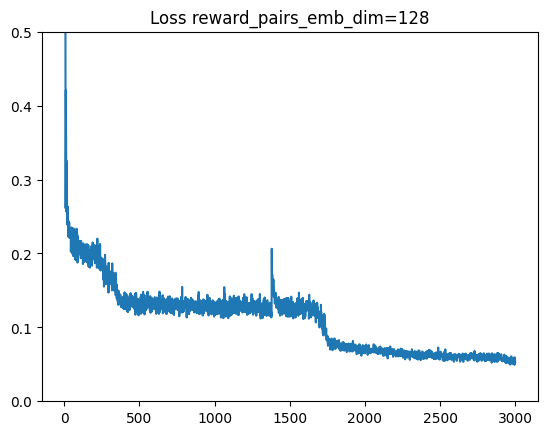

Eval: 100%|██████████| 50/50 [00:04<00:00, 10.49it/s]
/tmp/ipykernel_5681/695631648.py:49: RuntimeWarning: Mean of empty slice.
  pred_goal = observations[viz_ids][pred_rewards.reshape(-1).reshape(-1) > 0.0].mean(0)[[0, 1]]
/home/nazim/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


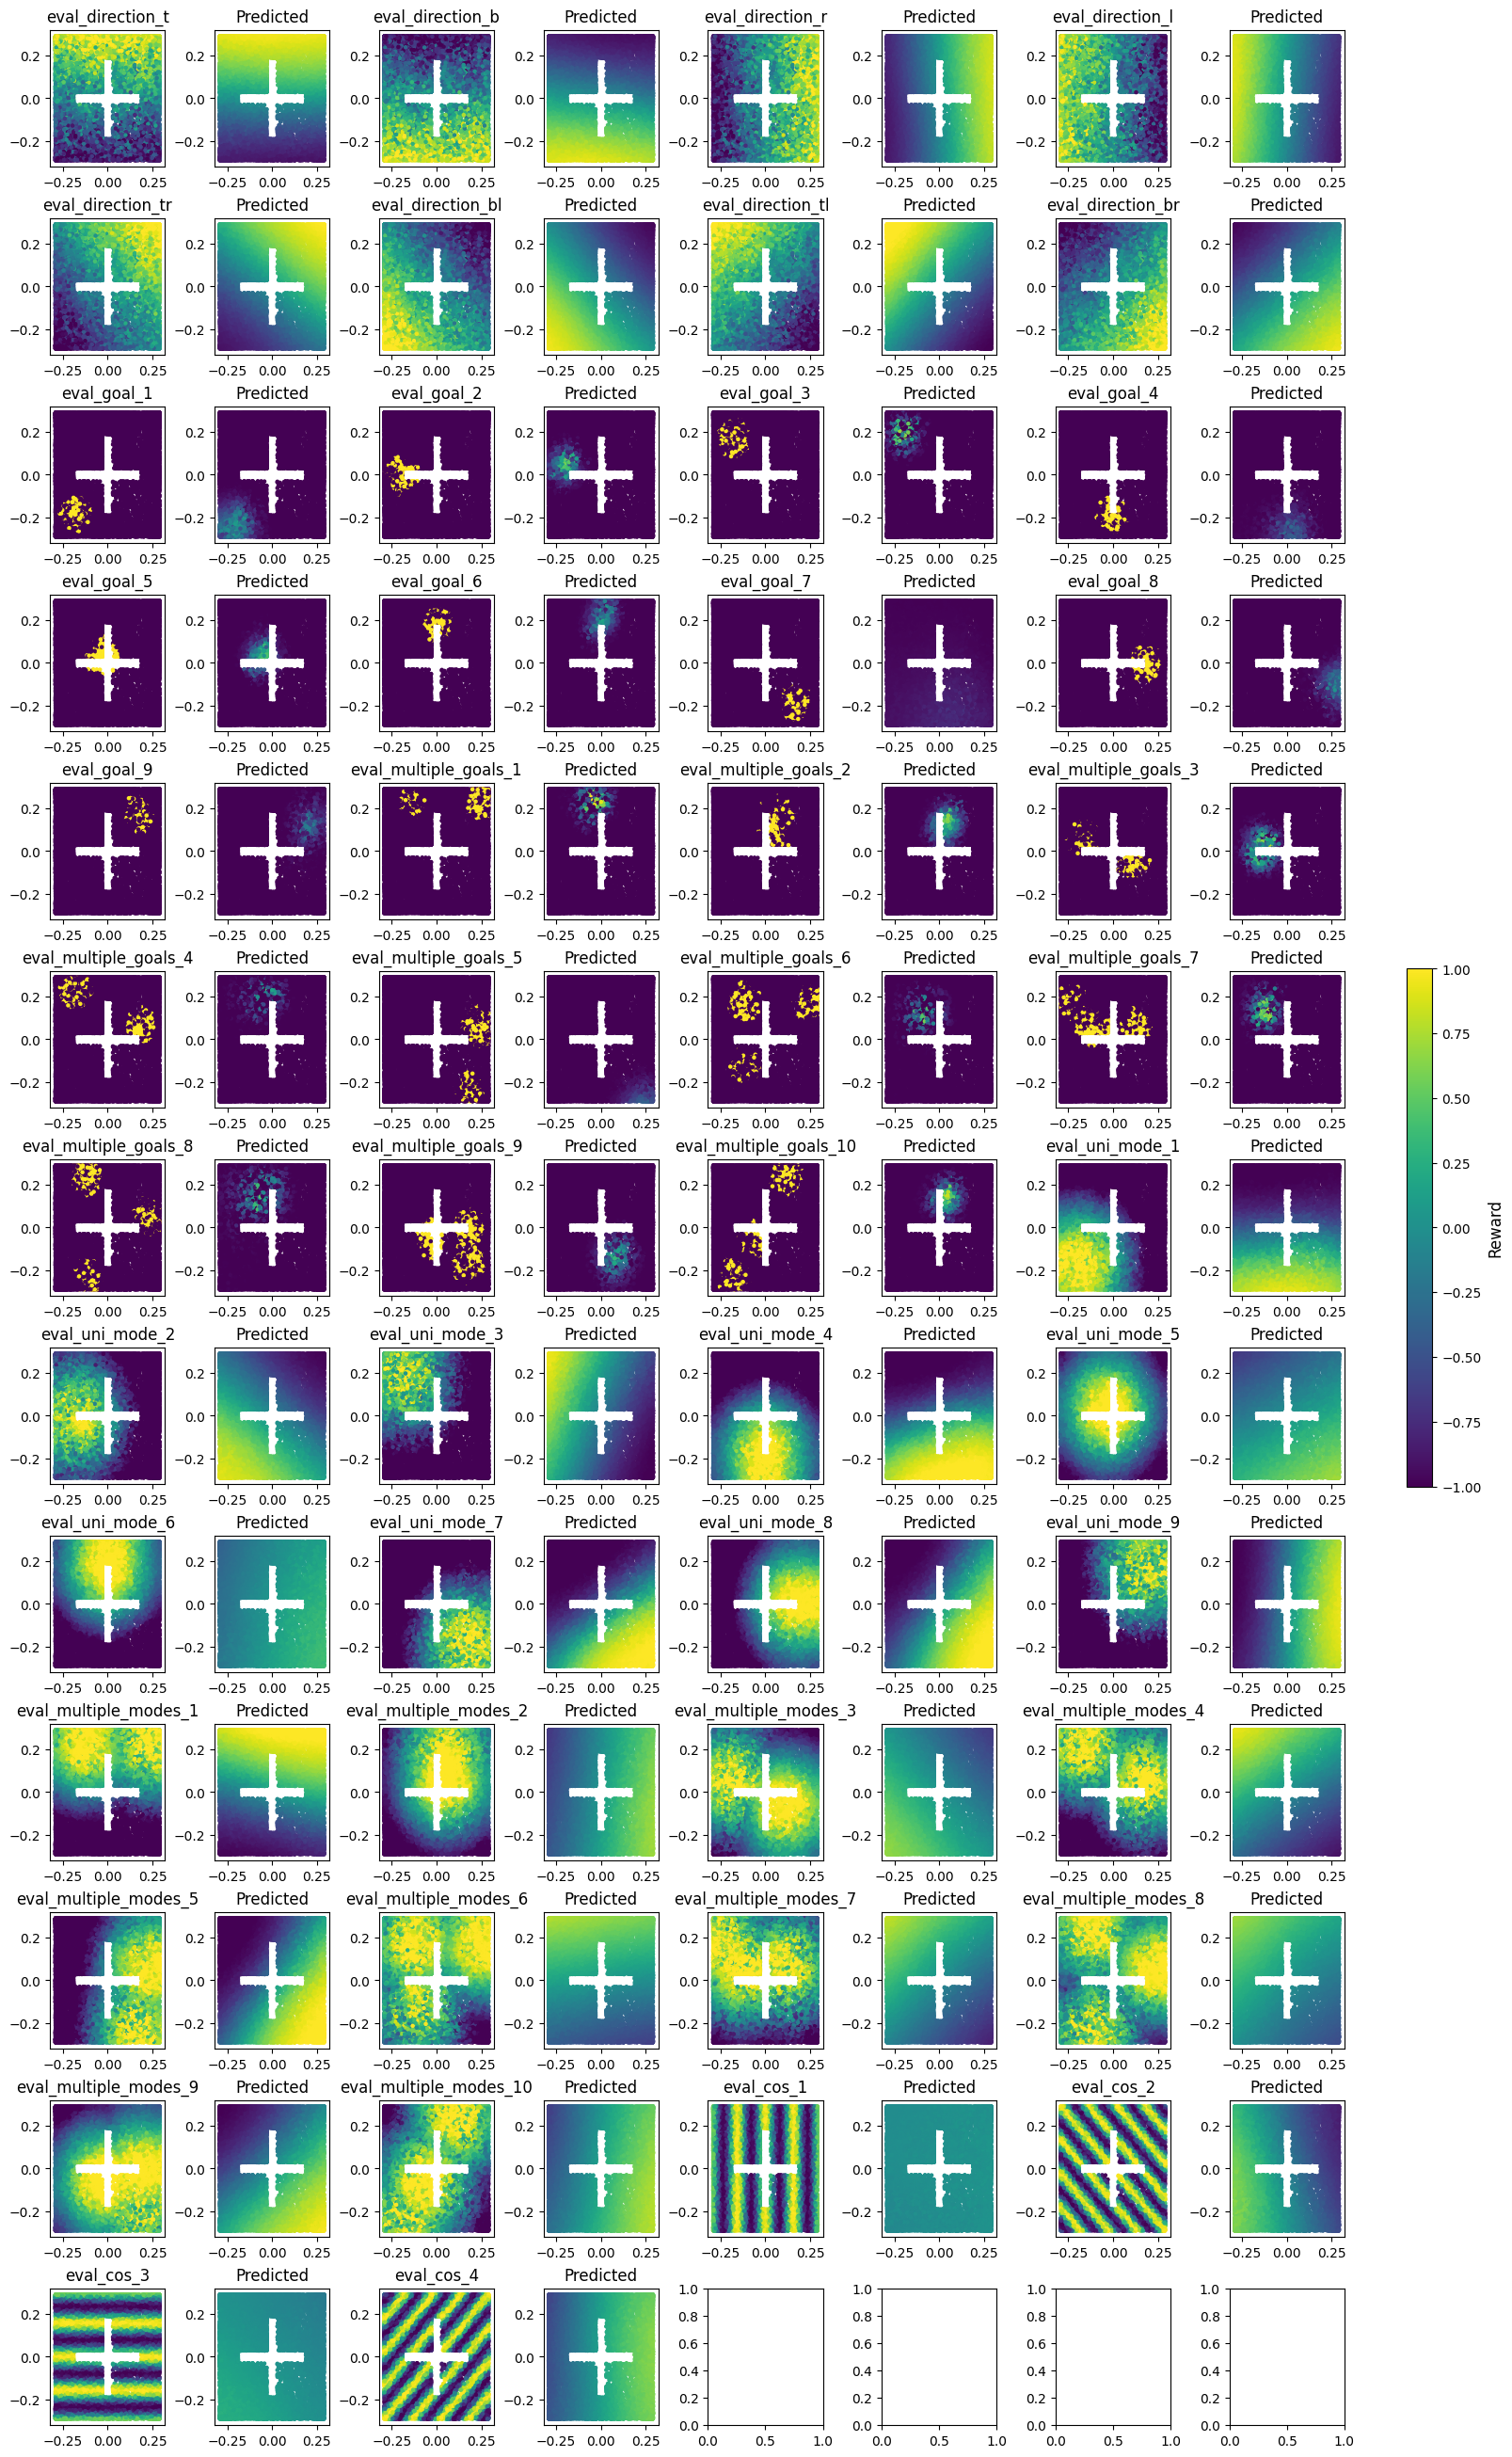

In [116]:
eval_random_rewards = RandomReward(mlp_N=10000, goal_N=10000)

reward_pairs_emb_dim_list, mlp_performance_list, goal_performance_list = [], [], []


for reward_pairs_emb_dim in [2, 4, 8, 16, 32, 64, 128, 256, 512]:
    
    mlp_p = 0.5

    train_size = int(len(observations) * 1)
    train_observations = observations[np.random.randint(0, len(observations), train_size)]
    
    # plt.scatter(train_observations[:, 0], train_observations[:, 1], s=1)
    # plt.title(f'Training states frac={frac}')
    # plt.show()
    
    train_random_rewards = RandomReward()
    fre_network = FRENetwork(reward_pairs_emb_dim=reward_pairs_emb_dim).to(device)
    optimimizer = torch.optim.Adam(fre_network.parameters(), lr=0.001)
    
    losses = train_fre(
        fre_network,
        optimimizer,
        train_observations,
        train_random_rewards,
        steps=3000,
        viz_loss=False
    )
    plt.plot(losses)
    plt.ylim([0, 0.5])
    plt.title(f'Loss reward_pairs_emb_dim={reward_pairs_emb_dim}')
    plt.show()
    
    
    # visualize_fre(fre_network, eval_random_rewards)
    
    # mlp_performance, goal_performance = get_fre_performance(fre_network, eval_random_rewards)
    mlp_performance, goal_performance = eval_benchmark(fre_network, viz=True)
    
    reward_pairs_emb_dim_list.append(reward_pairs_emb_dim)
    mlp_performance_list.append(mlp_performance)
    goal_performance_list.append(goal_performance)

/tmp/ipykernel_9295/20629768.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.tensor(self.random_goals[random_indices])


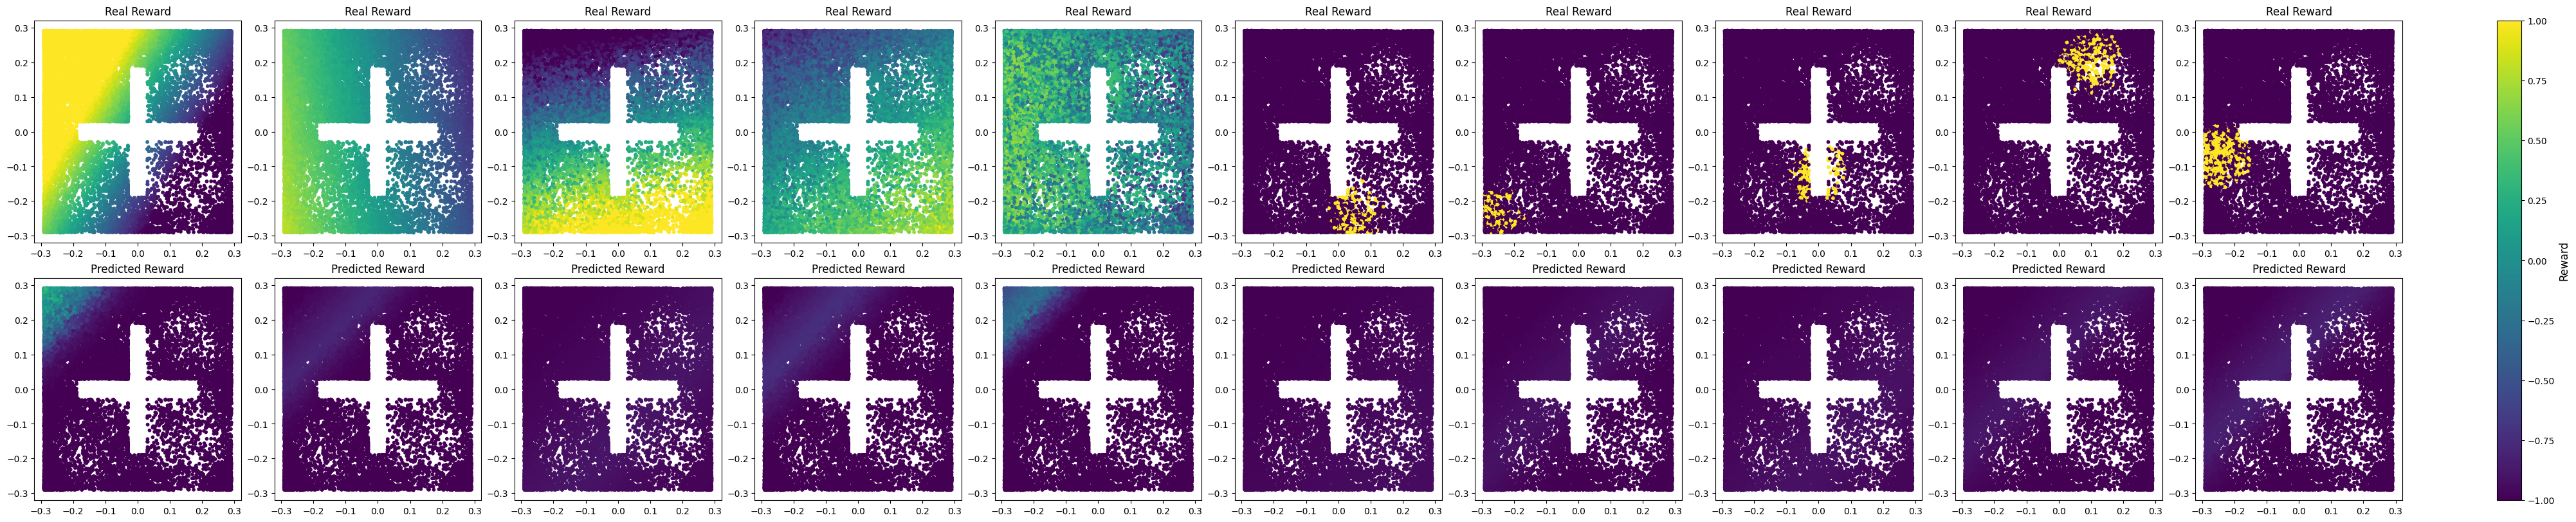

In [43]:
visualize_fre(fre_network, eval_random_rewards)

In [66]:
# [0.7145912981033326], [0.24742576]
mlp_performance_list, goal_performance_list

([0.2900471930205822,
  0.2956833443790674,
  0.12753668390214443,
  0.14305705912411212,
  0.1204648844897747,
  0.13936884738504887,
  0.45419810205698014],
 [nan, nan, nan, nan, 0.029081091, nan, nan])

In [ ]:
0.3973133243620396

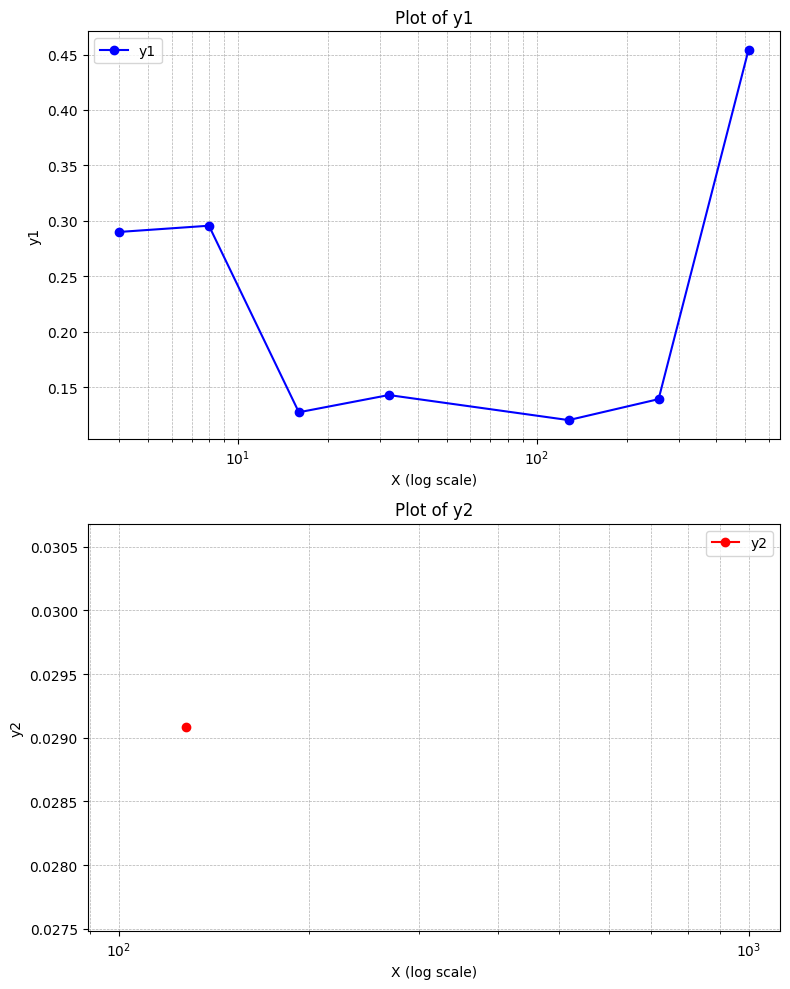

In [72]:
# Data
x = [4, 8, 16, 32, 128, 256, 512]
y1 = [0.2900471930205822, 0.2956833443790674, 0.12753668390214443, 
      0.14305705912411212, 0.1204648844897747, 0.13936884738504887, 0.45419810205698014]

y2 = [np.nan, np.nan, np.nan, np.nan, 0.029081091, np.nan, np.nan]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Plot y1
axs[0].plot(x, y1, marker='o', linestyle='-', color='b', label='y1')
axs[0].set_xscale('log')
axs[0].set_xlabel('X (log scale)')
axs[0].set_ylabel('y1')
axs[0].set_title('Plot of y1')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].legend()

# Plot y2
axs[1].plot(x, y2, marker='o', linestyle='-', color='r', label='y2')
axs[1].set_xscale('log')
axs[1].set_xlabel('X (log scale)')
axs[1].set_ylabel('y2')
axs[1].set_title('Plot of y2')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].legend()

# Show plot
plt.tight_layout()
plt.show()


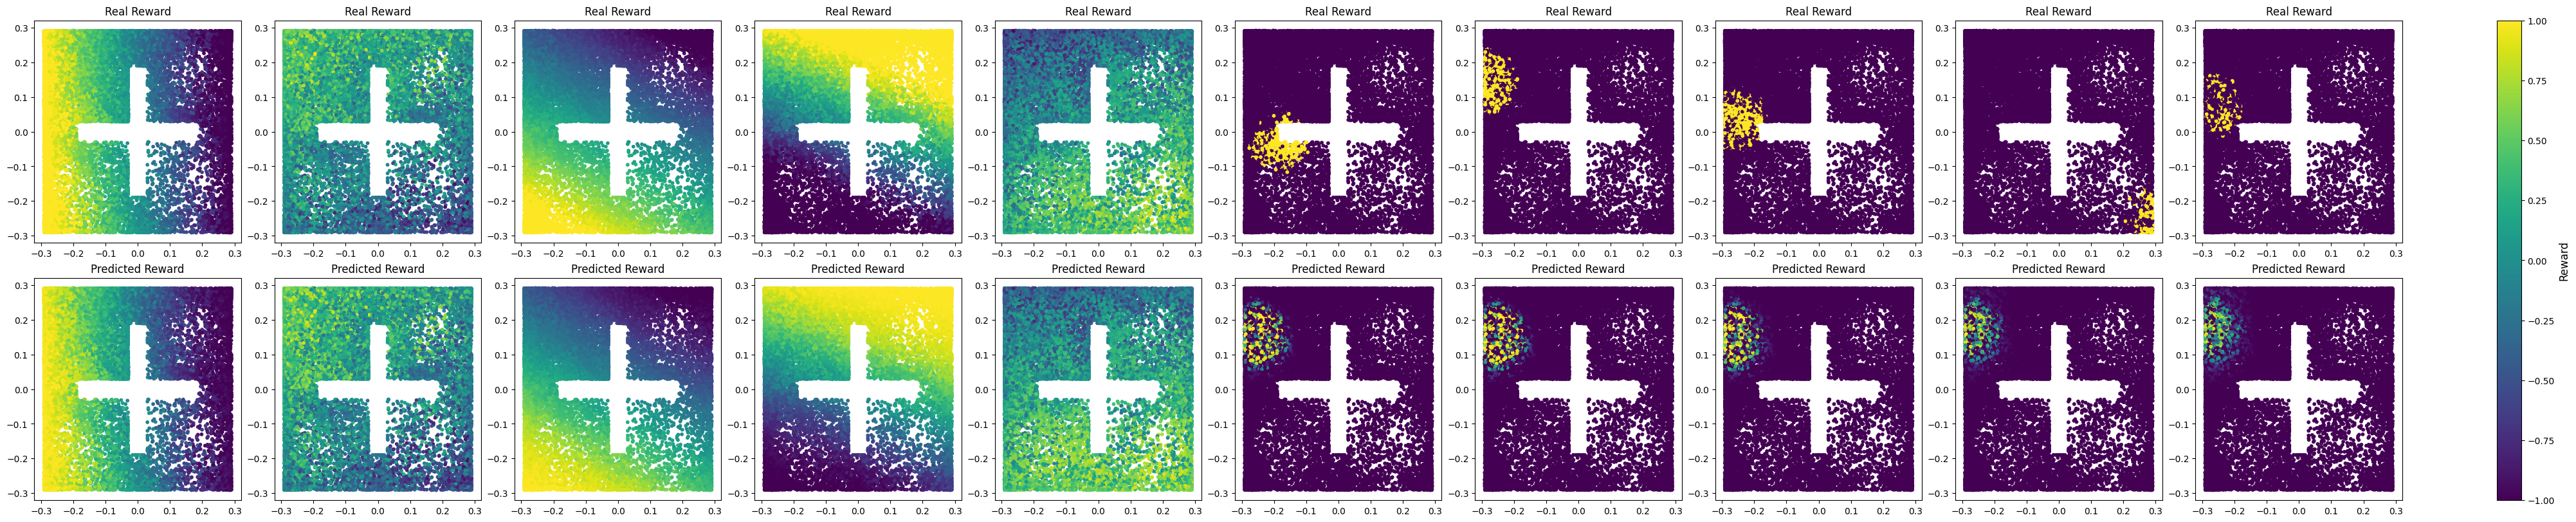

In [ ]:
visualize_fre(fre_network, random_rewards)

tensor(False)


/tmp/ipykernel_6435/949336720.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.tensor(self.random_goals[random_indices])


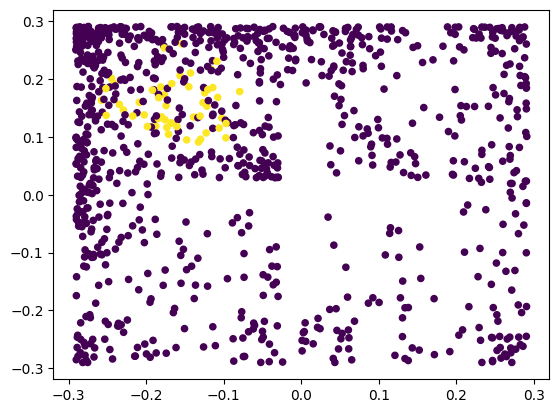

In [ ]:
random_rewards = RandomReward()

train_observations = observations
encode_samples = train_observations[torch.randint(0, train_observations.shape[0], (1*1000,))]
encode_obs = torch.tensor(encode_samples.reshape(1, 1000, 4)).to(device)

encode_rewards, (param_id, goals) = random_rewards(encode_obs, mlp_p=0)
print((encode_rewards == -1).all())
# print(encode_rewards.sort(descending=True).values)

plt.scatter(encode_samples[:, 0], encode_samples[:, 1], s=20, c=encode_rewards)


tensor(0.7982)